# Measure the Statistics of Pixel Noise

In [18]:
import ids
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pickle
import scipy.io as sio
import tqdm

## Some Code

In [2]:
EXPOSURE_VALUES = (100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 8000000)
GAIN_VALUES = range(0, 101, 20)
IDS_MAX_PIXEL_CLOCK = 30

class camera(object):
    """Wrapper around the camera driver

    The camera is set to use COLOR_BAYER_8 (RAW) mode.
    """
    
    def __init__(self):
        self._cam = ids.Camera(nummem=1)

        self._cam.auto_white_balance = False
        self._cam.continuous_capture = False
        self._cam.auto_exposure = False
        self._cam.exposure = 100    
        self._cam.color_mode = ids.ids_core.COLOR_BAYER_8
        self._cam.gain_boost = False
        self._cam.gain = 0
        
    @property
    def info(self):
        """Return information about the camera in a form of a dict"""

        return self._cam.info.copy()

    def capture(self, exposure_us, gain=0, gain_boost=False, average=10):
        """Capture a frame
        
        Args:
            exposure_us (int): Exposure period in useconds.
            gain (int): Master gain 0-100.
            gain_boost (bool): Whether to use analog gain boost.
            average (int): Number of frames to average.
            
        Retutns:
           image (array): Capture image (or average of images).
           exposure_ud (float): Actual exposure time (in useconds).
           gain (int): Actual gain.
        """
        
        #
        # Set pixelclock. These values are empiric.
        #
        if exposure_us > 1000:
            #
            # Set pixel rate to minimum to allow long exposure times.
            #
            print("Setting pixel clock to {}.".format(
                self._cam.pixelclock_range[0]))
            self._cam.pixelclock = \
                self._cam.pixelclock_range[0]
        else:
            #
            # Set pixel rate to maximum to allow short exposure times.
            #
            print("Setting pixel clock to {}.".format(IDS_MAX_PIXEL_CLOCK))
            self._cam.pixelclock = IDS_MAX_PIXEL_CLOCK

        #
        # Set frame rate.
        #
        self._cam.framerate = min(100, 1e6 / exposure_us)
        
        self._cam.exposure = exposure_us*1e-3
        self._cam.gain = gain
        self._cam.gain_boost = gain_boost
        
        #
        # Enable the camera and dispose of the first frame.
        #
        self._cam.continuous_capture = True
        try:
            _, _ = self._cam.next()
        
            imgs = []
            for i in tqdm.trange(average):
                img_array, meta_data = self._cam.next()
                imgs.append(img_array)
                
        finally:     
            self._cam.continuous_capture = False
        
        return imgs, self._cam.exposure * 1e3, self._cam.gain

## Setup

In [43]:
cam = camera()
cam_info = cam.info

base_path = os.path.join('results', cam_info['serial_num'])
if not os.path.isdir(base_path):
    os.makedirs(base_path)

In [48]:
data = cam.capture(exposure_us=50000, gain=0, gain_boost=False, average=10)
#plt.imshow(data[0], cmap="gray")

Setting pixel clock to 5.


100%|█████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


In [49]:
with open(os.path.join(base_path, "data_001.pkl"), "wb") as f:
    pickle.dump(data, f)

In [53]:
with open(os.path.join(base_path, "data_000.pkl"), "rb") as f:
    data = pickle.load(f)

In [54]:
def img2rgb(img):
    r = img[::2, ::2]
    g = np.mean((img[1::2, ::2], img[::2, 1::2]), axis=0)
    b = img[1::2, 1::2]
    return (r, g, b)

In [56]:
R, G, B = list(zip(*[img2rgb(i) for i in data[0]]))

In [58]:
ch_mean = [np.mean(ch, axis=0) for ch in (R, G, B)]
ch_std =[np.std(ch, axis=0) for ch in (R, G, B)]

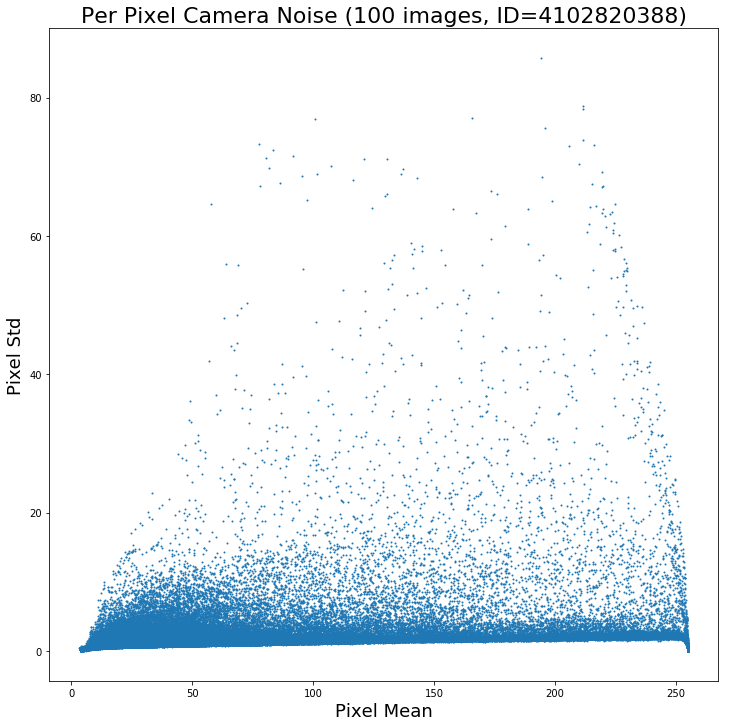

In [61]:
plt.figure(figsize=(12, 12))
plt.scatter(ch_mean[0].flatten(), ch_std[0].flatten(), s=1)
plt.title("Per Pixel Camera Noise ({} images, ID={})".format(len(data[0]), cam_info['serial_num']), fontsize=22)
plt.xlabel("Pixel Mean", fontsize=18)
plt.ylabel("Pixel Std", fontsize=18)

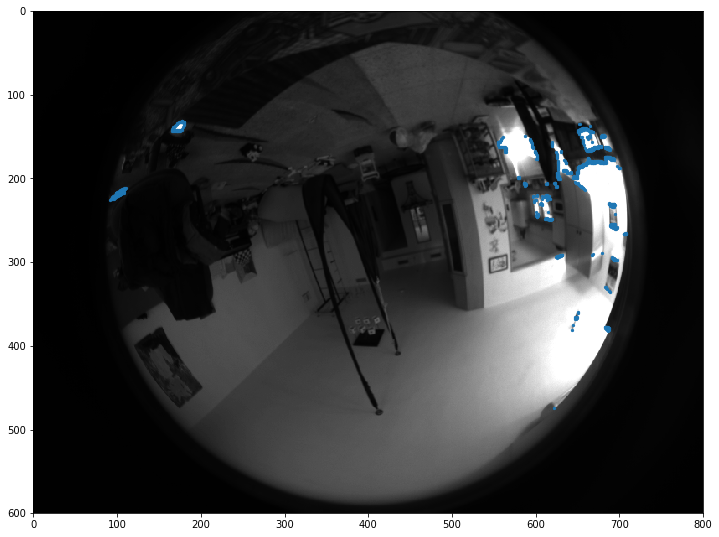

In [79]:
plt.figure(figsize=(12, 12))
plt.imshow(ch_mean[0], cmap="gray")
plt.scatter(nnz[1], nnz[0], s=5)

In [52]:
del cam

In [9]:
val, bins = np.histogram(data[0][0], bins=255)

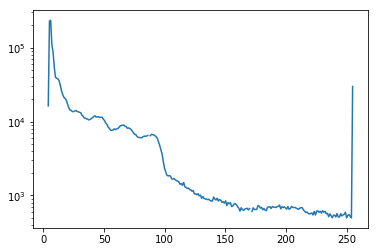

In [14]:
plt.semilogy(bins[1:], val)